# Demo of `litholog` functionality

litholog is a package-level extension of agile-geoscience/striplog, with additional features that focus on lithology, and an API that is geared toward facilitating machine learning and quantitative analysis.

The package provides two primary data structures:

- `Bed`
    - stores data from one bed (e.g., top, base, lithology, thickness, grain size, etc).
    - is equivalent to a `striplog.Interval`

- `BedSequence`
    - stores a collection of `Beds` in stratigraphic order 
    - is equivalent to a `striplog.Striplog`


Other utilities include:
- transformations for grain-size data from millimeter (mm) to log2 (a.k.a. Psi) units, which are far easier to work with than mm. 
- calculation of the following metrics at the `BedSequence` level:
    - net-to-gross
    - amalgamation ratio
    - psuedo gamma ray log
    - Hurst statistics (for determining facies clustering)
- default lithology colors

The data provided with this demo come from two papers, and all logs were digitized using the Matlab digitizer included with this release.
- 19 logs from Jobe et al. 2012 ([html](https://doi.org/10.1111/j.1365-3091.2011.01283.x), [pdf](https://www.dropbox.com/s/sgzmc1exd5vjd3h/2012%20Jobe%20et%20al%20Sed-%20Climbing%20ripple%20successions%20in%20turbidite%20systems.pdf?dl=0))
- 11 logs from Jobe et al. 2010 ([html](https://doi.org/10.2110/jsr.2010.092), [pdf](https://www.dropbox.com/s/zo12v3ixm86yt7e/2010%20Jobe%20et%20al%20JSR%20-%20Submarine%20channel%20asymmetry.pdf?dl=0)), 

An example log from that paper is shown here, drafted in a vector-drawing program:
<img src="../images/example_log.png" alt="Example graphic log from Jobe et al. (2012)" width="500"/>

When plotted with litholog looks like this:



# NOTES TO CHAT WITH ROSS ABOUT:
- I dont think the filter_nan_gaussian gets used? 
- component_map?
- tests folder?
- missing lithology NaNs
- making BedSeq from scratch
- to add:
    - wentworth demo
    - cleaning and io demo

---
---


## Import some packages, including `litholog`

In [5]:
import collections
import inspect

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import litholog
from litholog import utils, Bed
from litholog.sequence import io, BedSequence

In [2]:
#defaults legend for plotting
litholog.defaults.litholegend

Legend(Decor({'component': Component({'lithology': 'mud'}), '_colour': '#ad8150', 'hatch': None, 'width': -6.0})
Decor({'component': Component({'lithology': 'sand'}), '_colour': '#fffe7a', 'hatch': '.', 'width': -1.0})
Decor({'component': Component({'lithology': 'gravel'}), '_colour': '#ff9408', 'hatch': 'o', 'width': 4.0})
Decor({'component': Component({'lithology': 'missing'}), '_colour': '#ffffff', 'hatch': 'x', 'width': -1.0}))

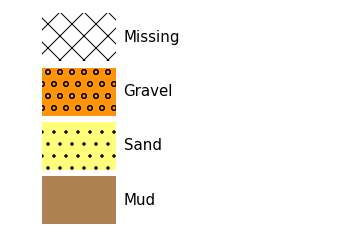

In [3]:
# and this is how Beds will look when plotted
litholog.defaults.litholegend.plot()

In [4]:
# modify the legend
litholog.defaults.sand_decor.colour = 'blue'

# and see if it worked
litholog.defaults.litholegend

Legend(Decor({'component': Component({'lithology': 'mud'}), '_colour': '#ad8150', 'hatch': None, 'width': -6.0})
Decor({'component': Component({'lithology': 'sand'}), '_colour': '#0000ff', 'hatch': '.', 'width': -1.0})
Decor({'component': Component({'lithology': 'gravel'}), '_colour': '#ff9408', 'hatch': 'o', 'width': 4.0})
Decor({'component': Component({'lithology': 'missing'}), '_colour': '#ffffff', 'hatch': 'x', 'width': -1.0}))

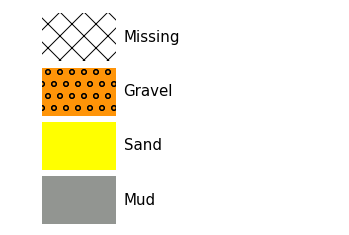

In [202]:
# modify things again
litholog.defaults.sand_decor.colour = 'yellow'
litholog.defaults.sand_decor.hatch = None

# call the plot function this time - note sand doesnt have dots any more
litholog.defaults.litholegend.plot()

# Make a `Bed` and a `BedSequence` from scratch
would be better to make a list of tops, bases, and zip it that way...

In [68]:
top, base = 1, 2
data = {'lit1': 5, 'arr1': [1,2,3], 'arr2': [4,5,6]}

B = litholog.Bed(top, base, data)
print(B.order)
B

depth


Interval({'data': {'lit1': 5, 'arr1': [1, 2, 3], 'arr2': [4, 5, 6]}, 'top': Position({'middle': 1.0, 'units': 'm'}), 'base': Position({'middle': 2.0, 'units': 'm'}), 'description': '', 'components': []})

In [205]:
bed1 = Bed(top = 1, base = 0, data = {'lithology':'sand'})
bed2 = Bed(top = 1.1, base = 1, data = {'lithology':'mud'})
bed3 = Bed(top = 1.8, base = 1.1, data = {'lithology':'sand'})

bed_x = Bed(0,1,{'lithology':'sand'})

print(bed2,'\n')

print(bed1.order)
print(bed_x.order,'\n')

print(bed1['lithology'])

TypeError: __init__() missing 1 required positional argument: 'base'

In [67]:
seq1 = BedSequence([bed1, bed2, bed3])
seq1

Striplog(3 Intervals, start=0.0, stop=1.8)

ValueError: min() arg is an empty sequence

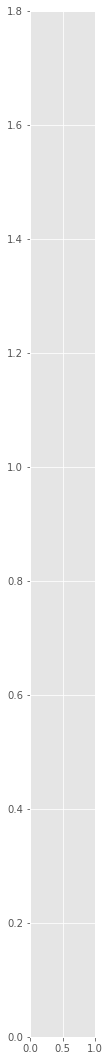

In [68]:
seq1.plot()

# Demo data

## Load the raw `csv` data

This first step uses `utils` within litholog to converts depth-grainsize pairs (e.g., that define a fining-upward profile in a bed) into pandas-friendly arrays. The outputs of this will be the fields shown below (e.g., depth_m, grain_size_mm). If you have differently formatted csv data, this step may not apply, or you may need a different util.

In [24]:
# Converts 'string' arrays to numpy
transforms = {c : utils.string2array_pandas for c in ['depth_m', 
                                                      'grain_size_mm', 
                                                      'grain_size_psi']}

# Read the demo data
df = pd.read_csv('../data/demo_data2.csv', converters=transforms)

# counts and prints the names of the logs in the data file
print(len(df.name.unique()),
      'graphic logs imported:',
      '\n',
      df.name.unique()) 

df.head() # displays the first five rows of data

30 graphic logs imported: 
 ['Pukearuhue' 'Magnolia' 'Karoo krf1' 'Karoo krf2' 'Karoo krf3'
 'Karoo krf4' 'Karoo krf5' 'Karoo krf6' 'Karoo krf7' 'Karoo krf8'
 'Karoo krf9' 'Karoo krf10' 'Karoo krf11' 'Karoo krf12' 'Karoo krf13'
 'Karoo krf14' 'Karoo krf15' 'Karoo krf16' 'Karoo krf17'
 'Sierra del Toro czm1' 'Sierra del Toro czm2' 'Sierra del Toro czm3'
 'Sierra del Toro czm4' 'Sierra del Toro czm5' 'Sierra del Toro dc1'
 'Sierra del Toro dc2' 'Sierra del Toro flame' 'Sierra del Toro h2o'
 'Sierra del Toro ssm' 'Sierra del Toro wc']


,name,collection,tops,th,gs_tops_mm,gs_tops_psi,snd_shl,mean_gs_mm,mean_gs_psi,max_gs_mm,max_gs_psi,ng,ar,depth_m,grain_size_mm,grain_size_psi
0,Pukearuhue,Mount Messenger,66.907008,0.234645,0.001000,-9.9658,0.0,0.001000,-9.9658,0.001000,-9.9658,0.602931,0.08134,"[66.907, 66.6724]","[0.001, 0.001]","[-9.9658, -9.9658]"
1,Pukearuhue,Mount Messenger,66.672363,0.933692,0.122591,-3.0281,1.0,0.129950,-2.9440,0.133845,-2.9014,0.602931,0.08134,"[66.6724, 66.5795, 66.3448, 66.1151, 65.9244, ...","[0.1226, 0.1262, 0.1285, 0.1315, 0.1331, 0.133...","[-3.028, -2.9862, -2.9602, -2.9269, -2.9094, -..."
2,Pukearuhue,Mount Messenger,65.738672,0.232201,0.105433,-3.2456,1.0,0.105433,-3.2456,0.105433,-3.2456,0.602931,0.08134,"[65.7387, 65.5065]","[0.1054, 0.1054]","[-3.2461, -3.2461]"
3,Pukearuhue,Mount Messenger,65.506471,0.222424,0.115450,-3.1147,1.0,0.137917,-2.8581,0.150254,-2.7345,0.602931,0.08134,"[65.5065, 65.4918, 65.4356, 65.372, 65.3476, 6...","[0.1154, 0.1203, 0.1306, 0.1446, 0.1503, 0.1503]","[-3.1153, -3.0553, -2.9368, -2.7899, -2.7341, ..."
4,Pukearuhue,Mount Messenger,65.284047,0.193093,0.110490,-3.1780,1.0,0.129487,-2.9491,0.141708,-2.8190,0.602931,0.08134,"[65.284, 65.2327, 65.1716, 65.1301, 65.091]","[0.1105, 0.1221, 0.1329, 0.1417, 0.1417]","[-3.1779, -3.0339, -2.9116, -2.8191, -2.8191]"


The variable `df` is just a pandas DataFrame at this point - it hasn't been put into `litholog` format yet. 

Notice that the columns `ng` (net-to-gross) and `ar` (amalgamation ratio) are the same for each graphic log. This csv was processed using Matlab, and `ng` and `ar` were calculated there. Not to worry, `litholog` can also calculate these metrics, which we will show you how to do below. 

--- 

---

## Convert groups to `BedSequence`s

This is the step that will convert `df` into `BedSequences` (equivalent to a `striplog.Striplog`) that contains `Beds` (equivalent to `striplog.Intervals`):

In [25]:
# Columns shared by whole sequences (i.e., shared by an entire graphic log)
METACOLS = ['name', 'collection', 'ng', 'ar']

# Columns of bed-level data
DATACOLS = ['th', 'gs_tops_mm', 'snd_shl', 'depth_m',
            'gs_tops_mm', 'mean_gs_mm', 'max_gs_mm', 'grain_size_mm',
            'gs_tops_psi', 'mean_gs_psi', 'max_gs_psi', 'grain_size_psi']

# Convert to a list of `BedSequence`s
seqs = []
for name, seq_df in df.groupby('name'):
    seqs.append(
        BedSequence.from_dataframe(
            seq_df, 
            thickcol='th',
            component_map=litholog.defaults.DEFAULT_COMPONENT_MAP,
            metacols=METACOLS,
            datacols=DATACOLS,
        )
    )
    

# Show name + eod + number of beds of each
[(s.metadata['name'], len(s)) for s in seqs]

[('Karoo krf1', 105),
 ('Karoo krf10', 221),
 ('Karoo krf11', 47),
 ('Karoo krf12', 35),
 ('Karoo krf13', 51),
 ('Karoo krf14', 96),
 ('Karoo krf15', 54),
 ('Karoo krf16', 167),
 ('Karoo krf17', 97),
 ('Karoo krf2', 20),
 ('Karoo krf3', 42),
 ('Karoo krf4', 15),
 ('Karoo krf5', 51),
 ('Karoo krf6', 288),
 ('Karoo krf7', 205),
 ('Karoo krf8', 244),
 ('Karoo krf9', 191),
 ('Magnolia', 180),
 ('Pukearuhue', 209),
 ('Sierra del Toro czm1', 79),
 ('Sierra del Toro czm2', 33),
 ('Sierra del Toro czm3', 55),
 ('Sierra del Toro czm4', 96),
 ('Sierra del Toro czm5', 118),
 ('Sierra del Toro dc1', 166),
 ('Sierra del Toro dc2', 44),
 ('Sierra del Toro flame', 63),
 ('Sierra del Toro h2o', 66),
 ('Sierra del Toro ssm', 54),
 ('Sierra del Toro wc', 38)]

In [26]:
# Choose one to use as an example
mag = seqs[-2] # the second to last one


print('This is a core, so it has order =\n',
      mag.order,
      '\nall other demo BedSequences are \'elevation\' ordered')

mag.values('top')

This is a core, so it has order =
 elevation 
all other demo BedSequences are 'elevation' ordered


TypeError: 'numpy.ndarray' object is not callable

In [27]:
mag.start, mag.stop

(Position({'middle': 0.0, 'upper': 0.0, 'lower': 0.0, 'units': 'm'}),
 Position({'middle': 65.99495201, 'units': 'm'}))

In [28]:
print(mag.metadata)

mag.metadata['ng']

{'name': 'Sierra del Toro ssm', 'collection': 'Cerro Toro', 'ng': 0.607889916, 'ar': 0.148148148}


0.607889916

In [29]:
print(type(mag.get_field('th')))
print(mag.get_field('th'))

<class 'numpy.ndarray'>
[2.30115381 0.13448302 2.53276345 0.65000124 1.70251761 0.11440395
 2.27173565 0.73545399 0.40128938 0.91202132 0.80987493 2.56021613
 0.08674654 0.65059908 0.49879263 1.42770354 0.36520843 1.64696757
 0.36250413 0.93410444 0.8749703  0.20539209 0.11501957 0.63011803
 1.04563246 0.84413037 0.10892005 0.9094824  0.32676014 2.78533022
 0.14018841 0.84286117 0.10903543 0.76661329 0.36857949 0.52081885
 0.20031494 0.15624565 0.44075646 1.11921999 0.63592045 0.17169852
 1.05562794 1.29308313 7.03981974 0.14640267 0.62390062 0.92664279
 2.7617331  1.68582241 1.21019243 2.62953795 6.22164738 5.98399271]


In [30]:
print('total thickness is',mag.get_field('th').sum(),'meters')
print('maximum Bed thickness is',mag.max_field('th'),'meters')
print('minimum Bed thickness is',mag.min_field('th'),'meters')

print(mag.unique)

total thickness is 65.994952011 meters
maximum Bed thickness is 7.039819744 meters
minimum Bed thickness is 0.086746545 meters
[(Component({'lithology': 'mud'}), 27.331179002999992), (Component({'lithology': 'sand'}), 19.418313176999987), (Component({'lithology': 'gravel'}), 19.245459830999998)]


Now let's take a look at one `Bed`. All `Beds` must have a `top`, `base`, and `data`, which can be array or dict-like

In [31]:
mag[0]

Interval({'data': {'th': 2.301153813, 'gs_tops_mm': 0.009271353000000001, 'snd_shl': 0.0, 'depth_m': array([65.995 , 63.6938]), 'mean_gs_mm': 0.009271353000000001, 'max_gs_mm': 0.009271353000000001, 'grain_size_mm': array([0.0093, 0.0093]), 'gs_tops_psi': -6.752999999999999, 'mean_gs_psi': -6.752999999999999, 'max_gs_psi': -6.752999999999999, 'grain_size_psi': array([-6.7486, -6.7486])}, 'top': Position({'middle': 65.99495201, 'units': 'm'}), 'base': Position({'middle': 63.69379819700001, 'units': 'm'}), 'description': '', 'components': [Component({'lithology': 'mud'})]})

In [33]:
mag[-1].base # if a log is elevation-ordered, the last bed should have a base at zero

upper,0.0
middle,0.0
lower,0.0


In [37]:
print(mag[-1].top.upper) # see the striplog Interval class for info on upper, middle, and lower
print(mag[-1].primary.lithology)
print(mag[-1].data['mean_gs_psi'])
print(litholog.wentworth.psi2name(mag[-1].data['mean_gs_psi']))
print(mag[-1].summary())

5.983992709
gravel
4.1499
c_gravel
5.98 m of gravel


In [63]:
# lets look at a covered interval
mag[-12]

Interval({'data': {'th': 1.055627945, 'gs_tops_mm': 0.19548374300000002, 'snd_shl': 1.0, 'depth_m': array([31.5784, 31.5339, 31.4258, 31.2477, 31.0061, 30.7644, 30.6309,
       30.5228]), 'mean_gs_mm': 0.220530914, 'max_gs_mm': 0.233113491, 'grain_size_mm': array([0.1955, 0.2078, 0.2094, 0.2159, 0.2226, 0.2278, 0.2331, 0.2331]), 'gs_tops_psi': -2.3549, 'mean_gs_psi': -2.1809, 'max_gs_psi': -2.1009, 'grain_size_psi': array([-2.3548, -2.2667, -2.2557, -2.2116, -2.1675, -2.1342, -2.101 ,
       -2.101 ])}, 'top': Position({'middle': 31.57840287, 'units': 'm'}), 'base': Position({'middle': 30.522774925, 'units': 'm'}), 'description': '', 'components': [Component({'lithology': 'sand'})]})

In [38]:
for bed in mag:
    print(bed.top.upper)
    
    

65.99495201
63.69379820000001
63.55931518
61.02655173
60.37655049
58.67403288
58.55962893
56.28789327
55.55243928
55.15114989999999
54.23912859
53.42925366
50.86903754
50.78229099
50.13169191
49.63289928
48.20519573
47.8399873
46.19301973
45.8305156
44.89641115
44.02144085
43.81604876
43.70102919
43.07091116
42.0252787
41.18114833
41.07222829
40.16274589
39.83598575
37.05065553
36.91046712
36.06760595
35.95857052
35.19195722
34.82337773
34.30255888
34.10224394
33.94599829
33.50524183
32.38602184
31.75010139
31.57840287
30.52277492
29.22969179
22.18987205
22.04346938
21.41956876
20.49292597
17.73119287
16.04537046
14.83517804
12.20564009
5.983992709


## Basic Plotting

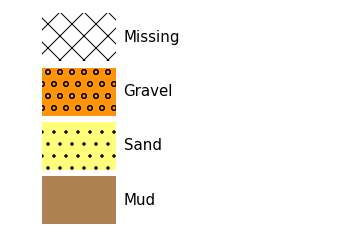

In [39]:
litholog.defaults.litholegend.plot()

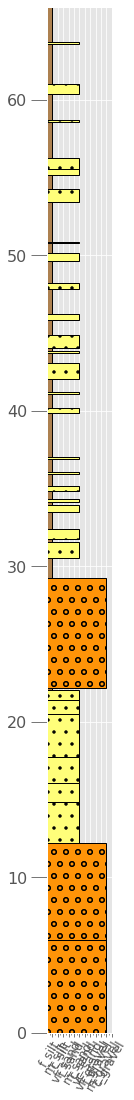

In [40]:
# the most simple plot, but doesnt include any bed-level grain size data
# since this is a core, it plots depth-ordered
mag.plot()


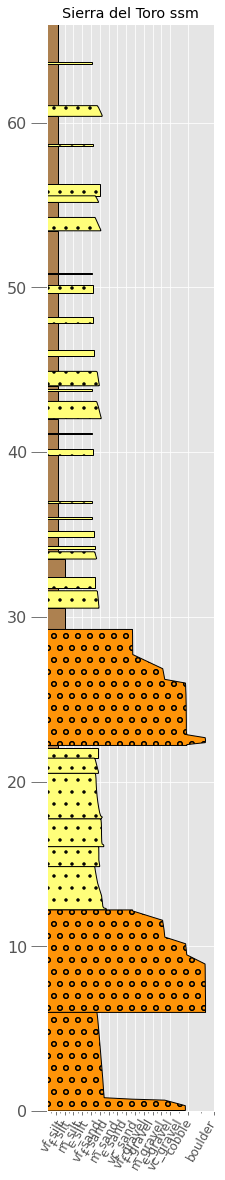

In [41]:
# here is a little nicer way to plot it that includes the grain size data for each bed

fig, ax = plt.subplots(figsize=[3,20])

seq_num = -2

seqs[seq_num].plot(ax=ax,
                   legend=litholog.defaults.litholegend,
                   width_field='grain_size_psi',
                   depth_field='depth_m',
                   wentworth='fine'
                  )

ax.set_title(seqs[seq_num].metadata['name']);

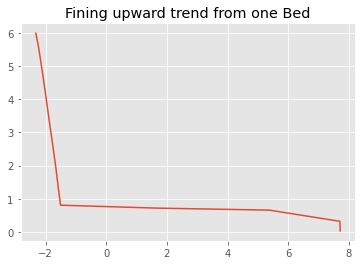

In [50]:
gs=mag[-1].data['grain_size_psi'] # get just one field from a Bed
de=mag[-1].data['depth_m'] 

plt.plot(gs,de)
if mag.order=='depth': 
    plt.gca().invert_yaxis()
    print('depth ordered')
    
plt.title('Fining upward trend from one Bed');

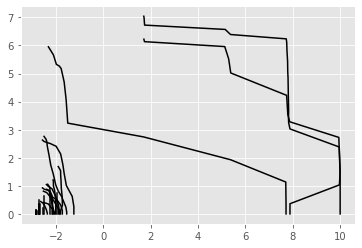

In [55]:
fig, ax = plt.subplots()
for bed in mag:
    if bed.data['snd_shl']==1.0:
        gs=bed.data['grain_size_psi']
        
        de=bed.data['depth_m']
        de=np.max(de)-de # normalize to zero so they will all plot together
        if mag.order=='elevation':
            de=np.flip(de)

        ax.plot(gs,de,'k')
#plt.gca().set_xlim([-3.5,-2]) # do this because some sand beds go all the way to clay

## Flipping depth -> elevation

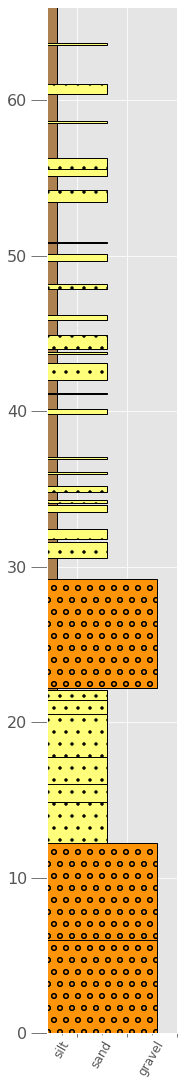

In [56]:
# depth version (this is only depth-ordered one in demo)
seqs[-2].plot(legend=litholog.defaults.litholegend, 
             fig_width=3, aspect=5, wentworth='coarse')

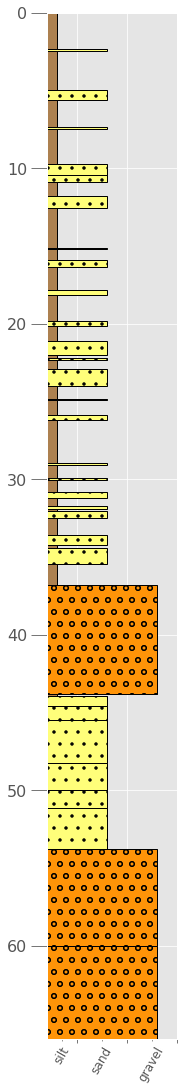

In [57]:
# to elevation
seqs[-2].flip_convention(depth_key='depth_m').plot(
             legend=litholog.defaults.litholegend, 
             fig_width=3, aspect=5, wentworth='coarse')

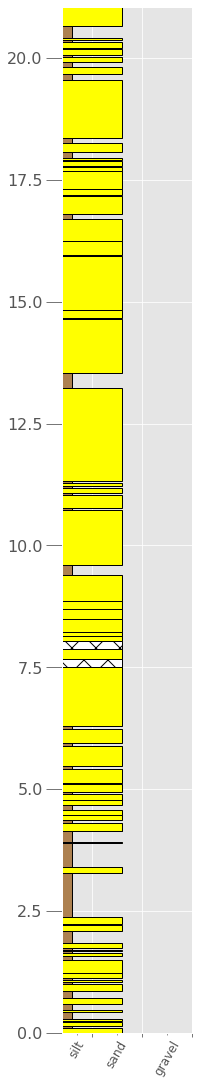

In [183]:
# Specify a legend when plotting (otherwise random used)
# `wentworth` can use 'fine' or 'coarse' bins

# elevation_version
example_seq.plot(legend=litholog.defaults.litholegend, 
                 fig_width=3, aspect=5, wentworth='coarse')

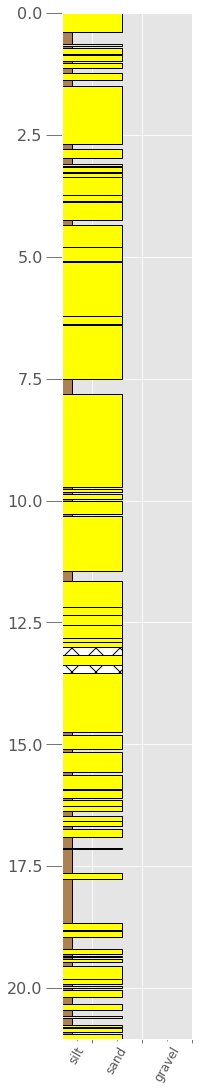

In [184]:
# to depth
example_seq.flip_convention(depth_key='depth_m').plot(
          legend=litholog.defaults.litholegend, 
          fig_width=3, aspect=5, wentworth='coarse')

In [185]:
example_seq.order

'elevation'

In [186]:
example_seq.shift(delta=-example_seq.stop.z).order

'depth'

# Some Basic Stats Properties

In [196]:
print(example_seq.metadata)

# Properties computed on the fly
print(example_seq.net_to_gross,';',example_seq.amalgamation_ratio)

print('N:G from Matlab:',round(example_seq.metadata['ng'],3),'\n',
      'N:G from litholog:',round(example_seq.net_to_gross,3))

{'name': 'Karoo krf1', 'count': 146, 'collection': 'Karoo', 'eod': 'fan', 'eodnum': 1, 'ng': 0.7726148858605799, 'ar': 0.104761904761905}
0.7726148858605802 ; 0.11
N:G from Matlab: 0.773 
 N:G from `litholog`: 0.773


In [188]:
# Hurst statistics
print(example_seq.hurst_K('th', 'sand'))

# Returns (D, p, hurst_K)
example_seq.hurst_D('th', 'sand', nsamples=10000)

0.822415106865567


(2.9331914147912252, 0.0006, 0.822415106865567)

# Pseudo-gamma curves

In [197]:
def suggest_figsize(sequence, aspect=10):
    """
    Defining default a total thickness -> figure size mapping.
    """
    suggest_h = max(10, min(sequence.cum, 50))
    suggest_w = suggest_h / aspect
    return (suggest_w, suggest_h)


def strip_fig_extra_columns(ax_num, sequence, ncols, exxon_style=True, figsize=None, aspect=10):
    """
    Creates a fig with `ncol` axes and plots `sequence` on one of them.
    If `exxon_style`, plots `sequence` on first axis, otherwise last axis.
    Returns
    -------
    fig, ax
    """
    w, h = suggest_figsize(sequence, aspect=aspect)
    print(w, h)

    fig, ax = plt.subplots(ncols=ncols, sharey=True, figsize=(w*ncols, h))
    #fig.subplots_adjust(wspace=0.)

    sequence.plot(legend=litholog.defaults.litholegend,
                  width_field='grain_size_psi',
                  depth_field='depth_m',
                  ax=ax[ax_num])

    return fig, ax

2.338050702353454 21.042456321181085


<ipython-input-198-0ffd3c904a72>:17: RuntimeWarning: invalid value encountered in less
  ax[1].fill_betweenx(ds, pgr, np.repeat(cutoff, ds.size), where=(pgr<cutoff), color='yellow')


(0.0, 200.0)

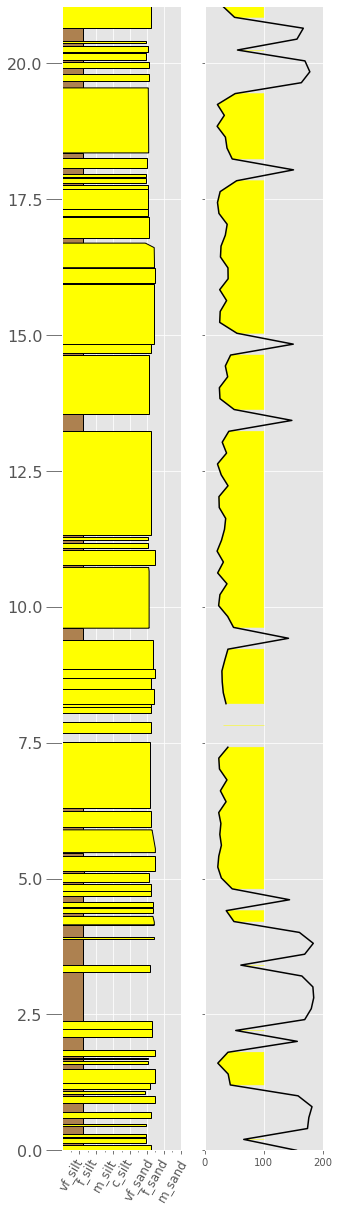

In [198]:
# Showing default values:
ds, pgr = example_seq.pseudo_gamma_simple(
    gs_field='grain_size_mm',
    depth_field='depth_m',
    resolution=0.2,
    gs_cutoff=0.0625,
    gamma_range=(30, 180),
    sigma=0.1,
    noise=10.
)

fig, ax = strip_fig_extra_columns(0, example_seq, 2, aspect=9)

cutoff = 100

ax[1].plot(pgr, ds, 'k')
ax[1].fill_betweenx(ds, pgr, np.repeat(cutoff, ds.size), where=(pgr<cutoff), color='yellow')

ax[1].set_xlim([0,200])

# Ignore below here for now

In [ ]:






def gradient_fill(x, y, ax, pos_or_neg,
                  fill_color=None,
                  **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.
    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    ax : a matplotlib Axes instance
        The axes to plot on.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.
    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    x[np.argwhere(np.isnan(x))] = 0.

    line, = ax.plot(x, y, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    alpha = line.get_alpha()
    alpha = 1.0 if alpha is None else alpha

    if pos_or_neg=='positive':
        alpha_gradient = np.linspace(0.2, alpha, 100)
        xmin, xmax = 0., ax.get_xlim()[1]
    else:
        alpha_gradient = np.linspace(alpha, 0.2, 100)
        xmin, xmax = ax.get_xlim()[0], 0.

    z = np.empty((1, 100, 4), dtype=float)
    z[:,:,-1] = alpha_gradient[None,:]

    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb

    ymin, ymax = y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.flipud(xy) if y[0] < y[1] else xy   # Have to flip order for 'depth'-ordered striplogs
    if pos_or_neg=='positive':
        xy = np.vstack([[xmin, ymax], xy, [xmin, ymin], [xmin, ymax]])
    else:
        xy = np.vstack([[xmax, ymax], xy, [xmax, ymin], [xmax, ymax]])

    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

    #ax.autoscale(True)
    return line, im

# Plotting with convolution "gamma ray"

In [ ]:
# using astropy.convolve for now

def pseudo_gamma_simple(seq):
    # Params that will be args in the API:
        
    gs_threshold = 0.0625   # Cutoff in mm
    gamma_range = (180, 30) # Low/High values
    resolution = 0.05       # Depth resolution
    sigma = 2              # Gaussian filter width
    noise_magnitude = 10.   # +/- noise to add
    
    ds, gs = seq.get_field('depth_m'), seq.get_field('grain_size_mm')
    
    # Needs to be increasing for `np.interp`
    if ds[0] > ds[-1]:
        ds, gs = ds[::-1], gs[::-1]
    
    # Resampling
    nsamples = np.abs(ds[0]-ds[-1]) // resolution + 1
    resampled_ds = np.linspace(ds[0], ds[-1], num=int(nsamples), endpoint=True)
    resampled_gs = np.interp(resampled_ds, ds, gs)
    
    # Thresholding gs -> GR
    nan_idxs = np.argwhere(np.isnan(resampled_gs))
    resampled_gs[nan_idxs] = gamma_range[0]
    sample_gr = np.where(resampled_gs < gs_threshold, gamma_range[0], gamma_range[1])
    
    # Gauss filter
    # using astropy.convolve for now
    kernel = Gaussian1DKernel(sigma) # divided by resolution?
    conv_gr = convolve(sample_gr, kernel)
    
    # Add noise (uniform) + restrict to positive + restore NaNs
    gr = conv_gr + np.random.uniform(-noise_magnitude, noise_magnitude, size=conv_gr.size)
    gr[gr < 0.] = 0.
    gr[nan_idxs] = np.nan
    
    return resampled_ds, gr


fig, ax = strip_fig_extra_columns(0, seqs[0], 2, aspect=9)

ds, gr = pseudo_gamma_simple(seqs[0])
gradient_fill(gr, ds, ax[1], 'positive', fill_color='y')
ax[1].set_xlim([0,200])

In [ ]:
from scipy.ndimage import gaussian_filter1d

def filter_nan_gaussian(arr, sigma):
    """

    (Allows intensity to leak into the NaN area.)

    Implementation from stackoverflow answer:
        https://stackoverflow.com/a/36307291/7128154
    """
    gauss = arr.copy()
    gauss[np.isnan(gauss)] = 0
    gauss = gaussian_filter1d(gauss, sigma=sigma, mode='constant', cval=0)

    norm = np.ones(shape=arr.shape)
    norm[np.isnan(arr)] = 0
    norm = gaussian_filter1d(norm, sigma=sigma, mode='constant', cval=0)

    # avoid RuntimeWarning: invalid value encountered in true_divide
    norm = np.where(norm==0, 1, norm)
    gauss = gauss/norm
    gauss[np.isnan(arr)] = np.nan
    return gauss

def pseudo_gamma_simple(seq):
    # Params that will be args in the API:
        
    gs_threshold = 0.0625   # Cutoff in mm
    gamma_range = (180, 30) # Low/High values
    resolution = 0.05       # Depth resolution
    sigma = 2              # Gaussian filter width
    noise_magnitude = 10.   # +/- noise to add
    
    ds, gs = seq.get_field('depth_m'), seq.get_field('grain_size_mm')
    
    # Needs to be increasing for `np.interp`
    if ds[0] > ds[-1]:
        ds, gs = ds[::-1], gs[::-1]
    
    # Resampling
    nsamples = np.abs(ds[0]-ds[-1]) // resolution + 1
    resampled_ds = np.linspace(ds[0], ds[-1], num=int(nsamples), endpoint=True)
    resampled_gs = np.interp(resampled_ds, ds, gs)
    
    # Thresholding gs -> GR
    nan_idxs = np.argwhere(np.isnan(resampled_gs))
    resampled_gs[nan_idxs] = gamma_range[0]
    sample_gr = np.where(resampled_gs < gs_threshold, gamma_range[0], gamma_range[1])
    
    # Gauss filter
    # using astropy.convolve for now
    #kernel = Gaussian1DKernel(sigma) # divided by resolution?
    #conv_gr = convolve(sample_gr, kernel)
    conv_gr = filter_nan_gaussian(sample_gr, sigma)
    
    # Add noise (uniform) + restrict to positive + restore NaNs
    gr = conv_gr + np.random.uniform(-noise_magnitude, noise_magnitude, size=conv_gr.size)
    gr[gr < 0.] = 0.
    gr[nan_idxs] = np.nan
    
    return resampled_ds, gr


fig, ax = strip_fig_extra_columns(0, seqs[0], 2, aspect=9)

cutoff = 100

ds, gr = pseudo_gamma_simple(seqs[0])
#gradient_fill(gr, ds, ax[1], 'positive', fill_color='y')

ax[1].plot(gr, ds)
ax[1].fill_betweenx(ds, gr, np.repeat(cutoff, ds.size), where=(gr<cutoff), color='yellow')

ax[1].set_xlim([0,200])

## these functions stolen from Matt Bauer



In [ ]:
import matplotlib as mpl

def rect(ax,x,y,w,h,c):
    #Make rectangle with plt.Rectangle((x,y@ Lower left),width,height,color)
    polygon = plt.Rectangle((x,y),w,h,color=c)
    #Add it to axis
    ax.add_patch(polygon)

def GR_fill(ax,X,Y):
    plt.plot(X,Y,lw=0)
    
    #Make a custom color ramp
    cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["yellow","yellow",'goldenrod','darkgoldenrod',"dimgrey",'black','black'])
    
    #Step distance
    dy = Y[1]-Y[0]
    
    #Max GR value
    N  = float(np.nanmax(X))
    
    #Make rectangles with color based on GR values
    for n, (x,y) in enumerate(zip(X,Y)):
        color = cmap(x/N)
        rect(ax,x,y,N-x,dy,color)
        
        
fig, ax = strip_fig_extra_columns(1 ,seqs[0], 2, aspect=9)

ds, gr = pseudo_gamma_simple(seqs[0])
ax[0].plot(gr,ds,'k')
GR_fill(ax[0], gr, ds)
ax[0].set_xlim([0,200])
ax[1].set_title(seqs[0].metadata['name'])
plt.show()
#plt.savefig('/Users/zanejobe/Desktop/testT.pdf')

In [ ]:
def pseudo_gamma_args(seq, gamma_range, resolution, sigma, noise_magnitude):
    # Params that will be args in the API:
        
    gs_threshold = 0.0625   # Cutoff in mm
    #gamma_range = (180, 30) # Low/High values
    #resolution = 0.05       # Depth resolution
    #sigma = 2              # Gaussian filter width
    #noise_magnitude = 10.   # +/- noise to add
    
    ds, gs = seq.get_field('depth_m'), seq.get_field('grain_size_mm')
    
    # Needs to be increasing for `np.interp`
    if ds[0] > ds[-1]:
        ds, gs = ds[::-1], gs[::-1]
    
    # Resampling
    nsamples = np.abs(ds[0]-ds[-1]) // resolution + 1
    resampled_ds = np.linspace(ds[0], ds[-1], num=int(nsamples), endpoint=True)
    resampled_gs = np.interp(resampled_ds, ds, gs)
    
    # Thresholding gs -> GR
    nan_idxs = np.argwhere(np.isnan(resampled_gs))
    resampled_gs[nan_idxs] = gamma_range[0]
    sample_gr = np.where(resampled_gs < gs_threshold, gamma_range[0], gamma_range[1])
    
    # Gauss filter
    # using astropy.convolve for now
    kernel = Gaussian1DKernel(sigma) # divided by resolution?
    conv_gr = convolve(sample_gr, kernel)
    
    # Add noise (uniform) + restrict to positive + restore NaNs
    gr = conv_gr + np.random.uniform(-noise_magnitude, noise_magnitude, size=conv_gr.size)
    gr[gr < 0.] = 0.
    gr[nan_idxs] = np.nan
    
    return resampled_ds, gr


In [238]:
# why NaNs here?
np.isnan(seqs[0].values).sum()

36

In [236]:
seqs[-1][0].data #pukearuhue first bed

{'th': 0.23464504599417105,
 'gs_tops_mm': 0.010289315855149,
 'snd_shl': 0.0,
 'depth_m': array([66.907 , 66.6724]),
 'mean_gs_mm': 0.010289315855149,
 'max_gs_mm': 0.010289315855149,
 'grain_size_mm': [0.0103, 0.0103],
 'gs_tops_psi': -6.6027,
 'mean_gs_psi': -6.6027,
 'max_gs_psi': -6.6027,
 'grain_size_psi': [-6.6012, -6.6012]}

In [235]:
# fixing weird mud bed thats a colloid at the top of the section...

# DID THIS GET CHANGED IN THE DATA FILE???
Puk=-1
seqs[Puk][0].data['gs_tops_mm'] = 0.010289315855149
seqs[Puk][0].data['mean_gs_mm'] = 0.010289315855149
seqs[Puk][0].data['mean_gs_mm'] = 0.010289315855149
seqs[Puk][0].data['max_gs_mm'] = 0.010289315855149
seqs[Puk][0].data['grain_size_mm'] = [0.0103, 0.0103]
seqs[Puk][0].data['gs_tops_psi'] = -6.6027
seqs[Puk][0].data['mean_gs_psi'] = -6.6027
seqs[Puk][0].data['max_gs_psi'] = -6.6027
seqs[Puk][0].data['grain_size_psi'] = [-6.6012, -6.6012]

In [ ]:
# Ross, what is this for? 
demo_names = ['Pukearuhue', 'Magnolia', 'Karoo krf']
seq_rows = [beds[beds['name'].str.contains(dn)] for dn in demo_names]
demo_df = pd.concat(seq_rows)
demo_df.to_csv('../data/demo_sequences.csv', index=False)


In [ ]:
# nice way to parse data to get only BedSequences with more than 20 sand beds
seqs = list(filter(lambda s: len(s.get_field('th', 'sand')) >= 20, sequences))



## Keep for depstrat

In [ ]:
# beds is the pandas dataframe of all the beds
beds.snd_shl.value_counts()
beds[beds.snd_shl == 1].th.sum()

count = {eod : 0 for eod in beds.eod.unique()}
meters = {eod : 0 for eod in beds.eod.unique()}

for _, grp in beds.groupby('count'):
    count[grp['eod'].values[0]] += 1
    meters[grp['eod'].values[0]] += grp.th.sum()
    
avgs = {k : meters[k] / count[k] for k in count.keys()}
print(avgs)

###

weird = {problem : [] for problem in ['has_null', 'th_mismatch', 'samples_mismatch']}

for name, seq in beds.groupby('count'):
    
    if seq.isnull().any().any():
        weird['has_null'].append(name)
    
    _, elev_good = io.check_thicknesses(seq, 'tops', 'th', 'elevation')
    _, depth_good = io.check_thicknesses(seq, 'tops', 'th', 'depth')
    if not (elev_good or depth_good):
        weird['th_mismatch'].append(name)
        
    if not io.check_samples(seq, 'depth_m', 'grain_size_mm'):
        weird['samples_mismatch'].append(name)
        
weird, {k : len(v) for k, v in weird.items()}

###

beds[beds.depth_m.apply(utils.safelen) != beds.grain_size_mm.apply(utils.safelen)]

###

